## Assignment

You are leading a project to analyze product performance at Stripe. We at Stripe are most interested in how the products are performing and growing as well as how to prioritize our product development efforts to maximize our growth. You have been provided an initial cut of data on a few flagship products, each of which is targeted at a specific user segment. From the data you've been given, please prepare a short presentation detailing your findings.

**Product Usage Table:**

|Label| Description|
| - | :- |  
| `merchant` | This is the unique ID of each Stripe user |
|`date` | Data is aggregated up to the month level for each Stripe user.|
|`product` | This is the Stripe product that the user is using to charge their customers.|
|`event` | This is an action within a product. For more details on how products are used, see "segment details" below|
|`count of events` |       |
|`usd_amount` |Total amount in cents and USD that was processed for that API call|

**Segment Table:**

This is a mapping of merchant IDs to the user segmentation we have.

|Label| Description|
| - | :- |
|`saas`| These businesses serve SaaS products which means they primarily charge their customers on a recurring basis (usually   monthly). We want them to use our Subscriptions payments product to charge regularly on a time interval.|
|`ecommerce` | These businesses use Stripe's shopping cart product and primarily sell physical or digital goods online. |
|`platforms` | These users are platforms upon which other users can sign up and charge for services through the Stripe API. Examples would include ridesharing services, delivery services, etc. (e.g. Lyft, Task Rabbit, Instacart) |


## Segment Details

### SaaS

SaaS users have two options when they process recurring payments. The recurring payments product allows them to schedule automatically recurring payments on a fixed schedule, but the merchants can also manually create charges on Stripe for their recurring payments. Our hope with the recurring payments product is to make it easy for all users to automate their payments. The product was launched in May 2013.

### E-Commerce Store

Our shopping cart product enables online e-commerce stores to sell goods. We track details on their website around the conversion funnel and actions that customers take. We can see when an item is viewed, added to the cart, when the checkout flow is initiated, and when it is completed with a payment submitted.

### Platforms

Our Marketplace product allows platforms to charge on behalf of other users and payout funds to each end automatically.



### Questions to guide thinking:

1. How are each of Stripe's products and segments performing and where are they headed?

2. Are there any issues with the products that we should address?

3. Given more time and access to more data, what would you want to dig deeper on?

4. How should we prioritize development for different products, given our limited resources?




In [160]:
# Write your code here
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from datetime import datetime

In [202]:
product = pd.read_csv("/Users/rosiebai/Downloads/product_usage.csv")
product = product[['Merchant', 'Date', 'Product', 'Event', 'Count of events', 'Usd Amount']]
product = product.dropna(how = 'all')
segmentation = pd.read_csv("/Users/rosiebai/Downloads/segmentation.csv")

In [203]:
# create the master file for analysis
data = product.merge(segmentation, on = "Merchant", how = 'left')

In [204]:
data.head()

,Merchant,Date,Product,Event,Count of events,Usd Amount,Segment
0,282t1vpldi,1/1/13,Basic API,Charge,33,329967.0,SaaS
1,282t1vpldi,1/2/13,Basic API,Charge,17,169983.0,SaaS
2,282t1vpldi,1/3/13,Basic API,Charge,20,199980.0,SaaS
3,282t1vpldi,1/4/13,Basic API,Charge,21,209979.0,SaaS
4,282t1vpldi,1/5/13,Recurring,Subscription.Charge,23,229977.0,SaaS


In [205]:
data.dtypes

Merchant            object
Date                object
Product             object
Event               object
Count of events      int64
Usd Amount         float64
Segment             object
dtype: object

In [206]:
data['Usd Amount']= data['Usd Amount']/100 # because the original amount was in cents.

In [207]:
def summarize_dataframe(df):
    summary_rows = []

    for col in df.columns:
        col_data = df[col]
        dtype = col_data.dtype
        summary = {
            'column': col,
            'dtype': str(dtype),
            'missing_values': col_data.isnull().sum(),
            'num_unique': np.nan,
            'unique_values': np.nan,
            'min': np.nan,
            'max': np.nan,
            'mean': np.nan,
            'std': np.nan
        }

        if pd.api.types.is_object_dtype(dtype):
            unique_vals = col_data.dropna().unique()
            summary['num_unique'] = len(unique_vals)
            summary['unique_values'] = unique_vals.tolist()

        elif pd.api.types.is_numeric_dtype(dtype):
            desc = col_data.describe()
            summary['min'] = desc.get('min', np.nan)
            summary['max'] = desc.get('max', np.nan)
            summary['mean'] = round(desc.get('mean', np.nan),2)
            summary['std'] = round(desc.get('std', np.nan),2)

        elif pd.api.types.is_datetime64_any_dtype(dtype):
            summary['min'] = col_data.min()
            summary['max'] = col_data.max()

        summary_rows.append(summary)

    return pd.DataFrame(summary_rows).set_index('column')


In [208]:
summary_df = summarize_dataframe(data)
summary_df

,dtype,missing_values,num_unique,unique_values,min,max,mean,std
column,,,,,,,,
Merchant,object,0,33.0,"[282t1vpldi, 2x5fpa2a9k9, 39rrckrzfr, 3r5r60f6...",NaN,NaN,NaN,NaN
Date,object,0,24.0,"[1/1/13, 1/2/13, 1/3/13, 1/4/13, 1/5/13, 1/6/1...",NaN,NaN,NaN,NaN
Product,object,0,4.0,"[Basic API, Recurring, Marketplaces, Cart]",NaN,NaN,NaN,NaN
Event,object,0,7.0,"[Charge, Subscription.Charge, Marketplace.Char...",NaN,NaN,NaN,NaN
Count of events,int64,0,NaN,NaN,11.0,199728.00,10099.00,22444.59
Usd Amount,float64,654,NaN,NaN,58.0,199761.72,37221.31,50048.96
Segment,object,0,3.0,"[SaaS, Platform, E-Commerce Store]",NaN,NaN,NaN,NaN


## Performance per Product & Segment

In [259]:
overall_performance = data.groupby(['Year','Segment', 'Product']).agg({
    'Count of events': ['sum','mean'],
    'Usd Amount' : ['sum','mean'],
    'Merchant':'nunique'
}).reset_index().round(0)
overall_performance

Year           Segment       Product Count of events          Usd Amount  \
                                                    sum     mean        sum   
0  2013  E-Commerce Store          Cart         3327761  10666.0  1708221.0   
1  2013          Platform  Marketplaces          232075   2469.0  6746691.0   
2  2013              SaaS     Basic API            8389    300.0   255072.0   
3  2013              SaaS     Recurring           18137    490.0   125436.0   
4  2014  E-Commerce Store          Cart         8615838  15385.0  3876886.0   
5  2014          Platform  Marketplaces          290027   2685.0  8573283.0   
6  2014              SaaS     Basic API           45872    917.0   609705.0   
7  2014              SaaS     Recurring          105855   1680.0   363049.0   

           Merchant  
      mean  nunique  
0  21900.0       10  
1  71773.0        9  
2   9110.0        3  
3   3390.0        7  
4  27692.0       13  
5  79382.0        9  
6  12194.0        6  
7   5763.0        9

In [212]:
# Convert to datetime
data['Date'] = pd.to_datetime(data['Date'], errors='coerce')
# Extract year, month, and year-month (while still datetime64)
data['Year'] = data['Date'].dt.year
data['Month'] = data['Date'].dt.month
data['Year-Month'] = data['Date'].dt.to_period('M') 

# Strip time to just date object
data['month_day'] = data['Date'].dt.strftime('%m-%d')

## Segment Daily Performance

In [234]:
# Segment performance per month
segment_daily_performance = data.groupby(['Segment','Year','month_day']).agg({
    'Count of events':'sum',
    'Usd Amount':'sum',
    'Merchant' :'nunique'
}).rename(columns = {
    'Count of events':'total_events',
    'Usd Amount':'total_usd_amount',
    'Merchant':'total_merchants'
}).reset_index()
segment_daily_performance['usd_amount_per_event'] = segment_daily_performance['total_usd_amount']/segment_daily_performance['total_events']

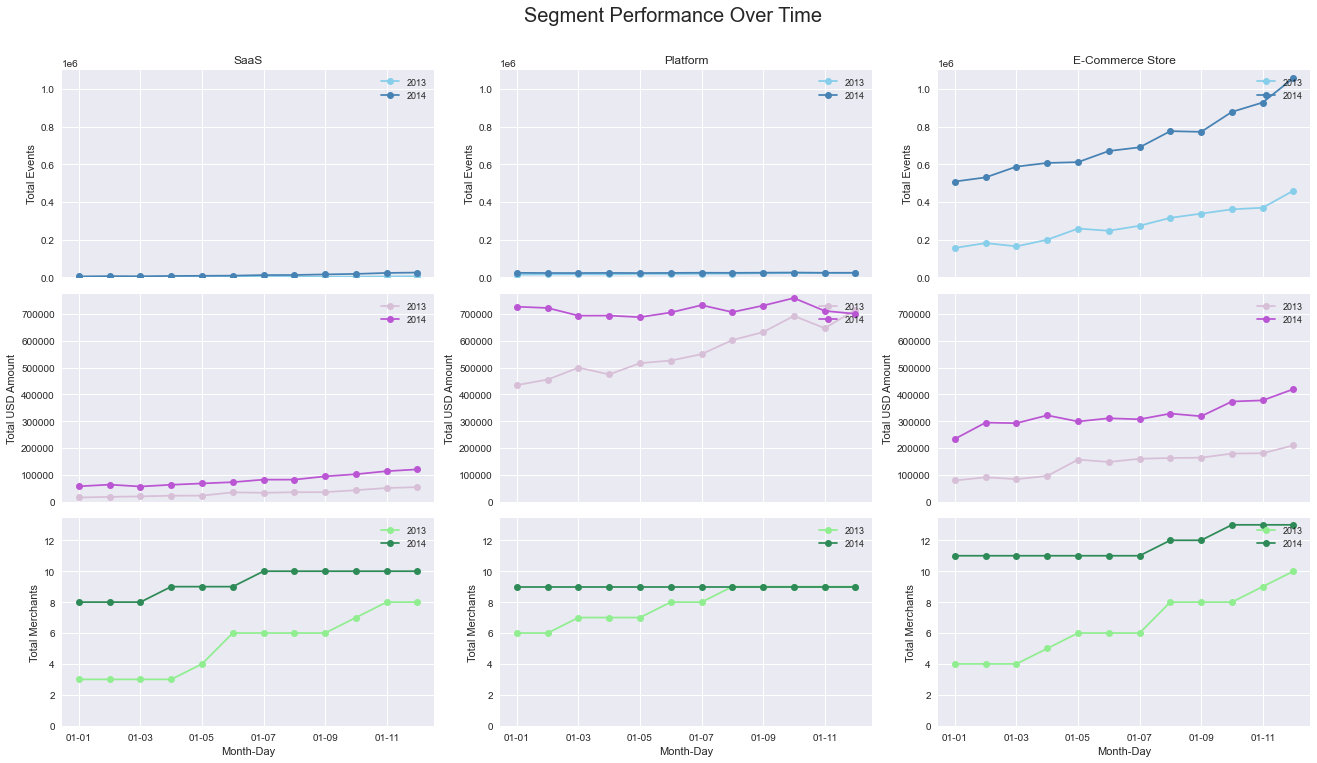

In [226]:
segments = data['Segment'].unique().tolist()
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(20, 12), sharex=True)

for i, segment in enumerate(segments):
    # Plot total_events (top row)
    pivot_events = segment_daily_performance[segment_daily_performance['Segment'] == segment] \
        .pivot_table(index='month_day', columns='Year', values='total_events', aggfunc='sum') \
        .sort_index()
    pivot_events.plot(kind='line', marker='o',
                      color={2013: 'skyblue', 2014: 'steelblue'},
                      ax=axes[0, i])
    axes[0, i].set_title(segment)
    axes[0, i].set_ylabel('Total Events')
    #axes[0, i].legend().set_visible(False)
    axes[0, i].legend(loc = 'upper right', fontsize = 9, frameon = False)
    axes[0, i].grid(True)

    # Plot total_usd_amount (2nd row)
    pivot_usd = segment_daily_performance[segment_daily_performance['Segment'] == segment] \
        .pivot_table(index='month_day', columns='Year', values='total_usd_amount', aggfunc='sum') \
        .sort_index()
    pivot_usd.plot(kind='line', marker='o',
                   color={2013: 'thistle', 2014: 'mediumorchid'},
                   ax=axes[1, i])
    axes[1, i].set_xlabel('Month-Day')
    axes[1, i].set_ylabel('Total USD Amount')
    #axes[1, i].legend().set_visible(False)
    axes[1, i].legend(loc = 'upper right', fontsize = 9, frameon = False)
    axes[1, i].grid(True)

    # Plot total_usd_amount (3rd row)
    pivot_merchants = segment_daily_performance[segment_daily_performance['Segment'] == segment] \
        .pivot_table(index='month_day', columns='Year', values='total_merchants', aggfunc='sum') \
        .sort_index()
    pivot_merchants.plot(kind='line', marker='o',
                   color={2013: 'lightgreen', 2014: 'seagreen'},
                   ax=axes[2, i])
    axes[2, i].set_xlabel('Month-Day')
    axes[2, i].set_ylabel('Total Merchants')
    axes[2, i].legend(loc = 'upper right', fontsize = 9, frameon = False)
    axes[2, i].grid(True)

# row-wise share y-axis
# Sync Y-axis for Total Events (top row)
max_y_events = max(ax.get_ylim()[1] for ax in axes[0])
for ax in axes[0]:
    ax.set_ylim(0, max_y_events)

# Sync Y-axis for Total USD Amount (2nd row)
max_y_usd = max(ax.get_ylim()[1] for ax in axes[1])
for ax in axes[1]:
    ax.set_ylim(0, max_y_usd)

max_y_merchants = max(ax.get_ylim()[1] for ax in axes[2])
for ax in axes[2]:
    ax.set_ylim(0, max_y_merchants)

# Shared title
fig.suptitle('Segment Performance Over Time', fontsize=20, y=0.93)

# Shared legend
handles, labels = axes[0,0].get_legend_handles_labels()
#fig.legend(handles, labels, title='Year')

# Layout adjustment
plt.tight_layout(rect=[0.03, 0.05, 0.95, 0.92])
plt.show()


## Product Daily Performance

In [228]:
product_daily_performance = data.groupby(['Product','Year','month_day']).agg({
    'Count of events':'sum',
    'Usd Amount':'sum',
    'Merchant' :'nunique'
}).rename(columns = {
    'Count of events':'total_events',
    'Usd Amount':'total_usd_amount',
    'Merchant':'total_merchants'
}).reset_index()
product_daily_performance

,Product,Year,month_day,total_events,total_usd_amount,total_merchants
0,Basic API,2013,01-01,210,15256.48,3
1,Basic API,2013,01-02,291,17515.26,3
2,Basic API,2013,01-03,355,19460.07,3
3,Basic API,2013,01-04,422,21902.83,3
4,Basic API,2013,01-05,292,292.00,1
...,...,...,...,...,...,...
87,Recurring,2014,01-08,9327,31199.00,5
88,Recurring,2014,01-09,11219,38001.41,5
89,Recurring,2014,01-10,13171,41761.31,6
90,Recurring,2014,01-11,16687,39979.63,5


In [232]:
product_daily_performance['usd_amount_per_event'] = product_daily_performance['total_usd_amount']/product_daily_performance['total_events']

In [233]:
product_daily_performance

,Product,Year,month_day,total_events,total_usd_amount,total_merchants,usd_amount_per_event
0,Basic API,2013,01-01,210,15256.48,3,72.649905
1,Basic API,2013,01-02,291,17515.26,3,60.189897
2,Basic API,2013,01-03,355,19460.07,3,54.817099
3,Basic API,2013,01-04,422,21902.83,3,51.902441
4,Basic API,2013,01-05,292,292.00,1,1.000000
...,...,...,...,...,...,...,...
87,Recurring,2014,01-08,9327,31199.00,5,3.345020
88,Recurring,2014,01-09,11219,38001.41,5,3.387237
89,Recurring,2014,01-10,13171,41761.31,6,3.170702
90,Recurring,2014,01-11,16687,39979.63,5,2.395855


In [229]:
plt.style.use('seaborn')  # Apply style first
Products = data['Product'].unique().tolist()

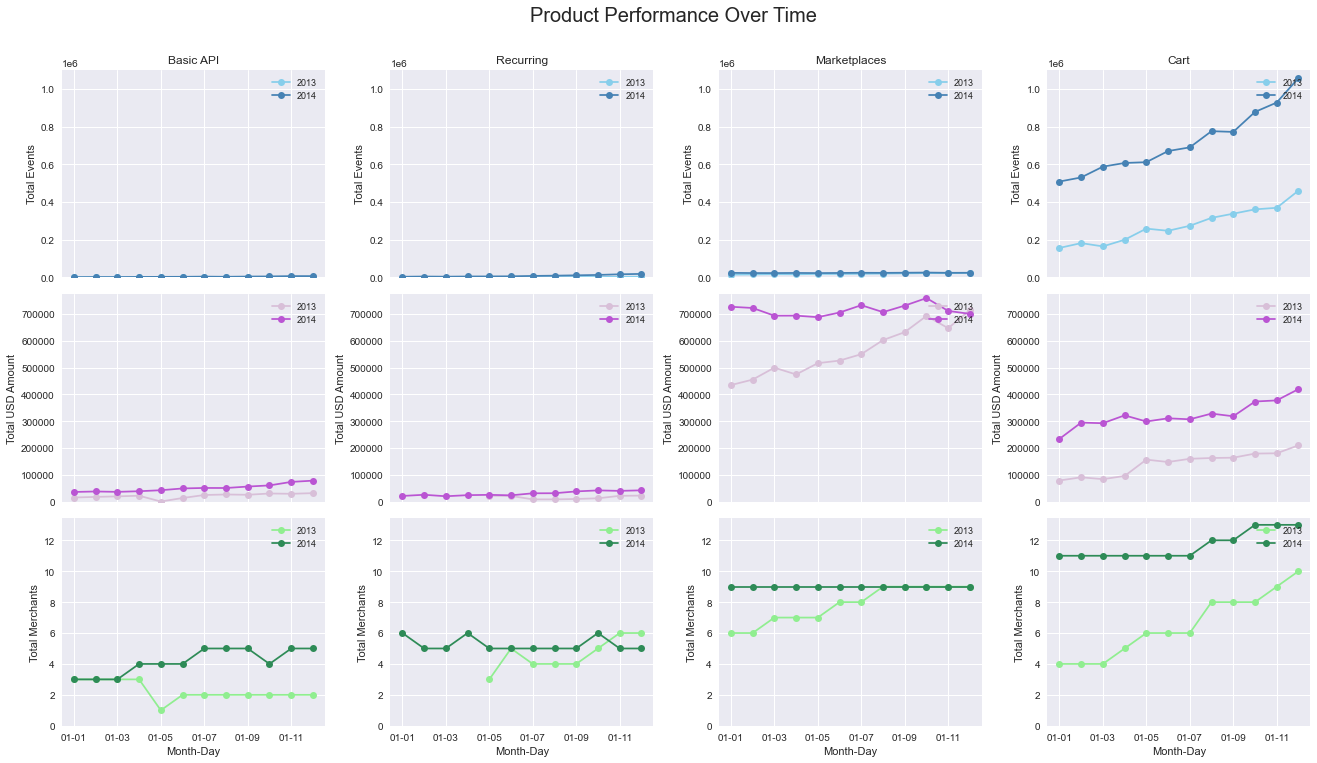

In [244]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(20, 12), sharex=True)

for i, Product in enumerate(Products):
    # Plot total_events (top row)
    pivot_events = product_daily_performance[product_daily_performance['Product'] == Product] \
        .pivot_table(index='month_day', columns='Year', values='total_events', aggfunc='sum') \
        .sort_index()
    pivot_events.plot(kind='line', marker='o',
                      color={2013: 'skyblue', 2014: 'steelblue'},
                      ax=axes[0, i])
    axes[0, i].set_title(Product)
    axes[0, i].set_ylabel('Total Events')
    #axes[0, i].legend().set_visible(False)
    axes[0, i].legend(loc='upper right', fontsize=9, frameon=False)

    axes[0, i].grid(True)

    # Plot total_usd_amount 
    pivot_usd = product_daily_performance[product_daily_performance['Product'] == Product] \
        .pivot_table(index='month_day', columns='Year', values='total_usd_amount', aggfunc='sum') \
        .sort_index()
    pivot_usd.plot(kind='line', marker='o',
                   color={2013: 'thistle', 2014: 'mediumorchid'},
                   ax=axes[1, i])
    axes[1, i].set_xlabel('Month-Day')
    axes[1, i].set_ylabel('Total USD Amount')
    # axes[1, i].legend().set_visible(False)
    axes[1, i].legend(loc='upper right', fontsize=9, frameon=False)
    axes[1, i].grid(True)

    # Plot total_merchants 
    pivot_merchants = product_daily_performance[product_daily_performance['Product'] == Product] \
        .pivot_table(index='month_day', columns='Year', values='total_merchants', aggfunc='sum') \
        .sort_index()
    pivot_merchants.plot(kind='line', marker='o',
                   color={2013: 'lightgreen', 2014: 'seagreen'},
                   ax=axes[2, i])
    axes[2, i].set_xlabel('Month-Day')
    axes[2, i].set_ylabel('Total Merchants')
    # axes[1, i].legend().set_visible(False)
    axes[2, i].legend(loc='upper right', fontsize=9, frameon=False)
    axes[2, i].grid(True)

#row-wise share y-axis
# Sync Y-axis for Total Events (top row)
max_y_events = max(ax.get_ylim()[1] for ax in axes[0])
for ax in axes[0]:
   ax.set_ylim(0, max_y_events)
#Sync Y-axis for Total USD Amount 
max_y_usd = max(ax.get_ylim()[1] for ax in axes[1])
for ax in axes[1]:
    ax.set_ylim(0, max_y_usd)
#Sync Y-axis for Total USD Amount 
max_y_merchants = max(ax.get_ylim()[1] for ax in axes[2])
for ax in axes[2]:
    ax.set_ylim(0, max_y_merchants)

# Shared title
fig.suptitle('Product Performance Over Time', fontsize=20, y=0.93)

# Shared legend
handles, labels = axes[0, 0].get_legend_handles_labels()
#fig.legend(handles, labels, title='Year')

# Layout adjustment
plt.tight_layout(rect=[0.03, 0.05, 0.95, 0.92])
plt.show()


## Event type analysis

In [246]:
data.groupby(['Product', 'Event']).agg({
            'Count of events': 'sum',
            'Usd Amount': 'sum'
        }).rename(columns={
            'Count of events': 'total_events',
            'Usd Amount': 'total_usd_amount'
        }).reset_index()

,Product,Event,total_events,total_usd_amount
0,Basic API,Charge,54261,864776.66
1,Cart,Cart.AddItem,1652213,0.00
2,Cart,Cart.Checkout,1195557,0.00
3,Cart,Cart.PaymentSubmit,278835,5585106.70
4,Cart,Cart.ViewItem,8816994,0.00
5,Marketplaces,Marketplace.Charge,522102,15319974.38
6,Recurring,Subscription.Charge,123992,488484.73


In [245]:
cart_order = [
    'Cart.ViewItem',
    'Cart.AddItem',
    'Cart.Checkout',
    'Cart.PaymentSubmit'
]

cart_data = data[data['Product']== 'Cart']
# Group and aggregate
df = (
    cart_data.groupby(['Product', 'Event'])
        .agg({
            'Count of events': 'sum',
            'Usd Amount': 'sum'
        })
        .rename(columns={
            'Count of events': 'total_events',
            'Usd Amount': 'total_usd_amount'
        })
        .reset_index()
)

# Set custom categorical order for Cart events
df['Event'] = pd.Categorical(df['Event'], categories=cart_order, ordered=True)

# Optional: filter only Cart product (if needed) and sort
df = df.sort_values(by=['Product', 'Event']).reset_index(drop=True)
df

,Product,Event,total_events,total_usd_amount
0,Cart,Cart.ViewItem,8816994,0.0
1,Cart,Cart.AddItem,1652213,0.0
2,Cart,Cart.Checkout,1195557,0.0
3,Cart,Cart.PaymentSubmit,278835,5585106.7


In [248]:
add_item_pct = round(1652213/8816994,2)
add_item_pct

0.19

In [249]:
checkout_pct = round(1195557/8816994,2)
checkout_pct

0.14

In [250]:
payment_submission_pct =  round(278835/8816994,2)
payment_submission_pct

0.03

## Summary:

1. 
- Among all segments, E-commerce store had the highest total events, but Platform had processed the highest amount of USD in Jan 2013 and Jan 2014.
- Among all products, Cart had the highest total events, but Marketplaces had processed the highest amount of USD in Jan 2013 and Jan 2014. 
- On a high level, 2014 Jan had better performance than 2013 Jan across the board.
- Cart product will continue to grow in a faster speed, compared with other products. 
2.  Product Issues: 
- SaaS Basic API on average had the lowest number of events in Jan of both years, SaaS Recurring product on avearge had the lowest amount of USD processed.
- For the Cart products, the checkout rate is 14%. And the payment submission rate is only 3%. Is there anyway to increase payment submission rate? We need to find out why the payment submission rate is so low.  
3. Given that SaaS product was launched in May 2013 but there was no data provided except Jan 2013 and Jan 2014. If we had more data, I would measure the effectiveness of this product launch. I would do a Pre vs. Post Comparison by using a statistical test like a t-test or Mann-Whitney U to test for significant differences.
4. As for what products to prioritize next: Marketplaces processed the most amount of USD and Cart product had the most number of events, so I would continue to prioritize these two, what's more, we need to continue to promote SaaS products. 